# 0. Import packages

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from glob import glob
from scipy import signal
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import detrend
from tqdm import tqdm
import obspy
from obspy.signal.trigger import recursive_sta_lta, plot_trigger, trigger_onset
import pickle as pkl

import copy


import pandas as pd
import rasterio
from rasterio.plot import show
from scipy.stats import gaussian_kde

from datetime import timedelta
import datetime
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

def sintela_to_datetime(sintela_times):
    '''
    returns an array of datetime.datetime 
    ''' 
    
    days1970 = datetime.datetime.date(datetime.datetime(1970, 1, 1)).toordinal()

    # Vectorize everything
    converttime = np.vectorize(datetime.datetime.fromordinal)
    addday_lambda = lambda x : datetime.timedelta(days=x)
    adddays = np.vectorize(addday_lambda )
    
    day = days1970 + sintela_times/1e6/60/60/24
    thisDateTime = converttime(np.floor(day).astype(int))
    dayFraction = day-np.floor(day)
    thisDateTime = thisDateTime + adddays(dayFraction)

    return thisDateTime

def preprocessing_step(file):

    # Load data #
    f = h5py.File(file)
    attrs = f['Acquisition'].attrs
    data = f['Acquisition']['Raw[0]']['RawData'][:]
    this_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
    times = sintela_to_datetime(this_time)
    x = np.linspace(0,data.shape[1],data.shape[1]) * attrs['SpatialSamplingInterval']
    

    fs = attrs['PulseRate'] #sample rate
    data_normed = chan_norm(data)
    #filter
    sos = signal.butter(10, 1, 'hp', fs=fs, output='sos')
    filtered = signal.sosfiltfilt(sos, data_normed, axis=0)


    if file[-9:-7] != '00':
        time_start = times[0] - datetime.timedelta(seconds=times[0].second, microseconds=times[0].microsecond)
        forward_step = np.arange(time_start, times[0], 500).shape[0]
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500]) + forward_step -1
    else:
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500])



    # this_time = np.arange(0,int(fs*60))* 500 + this_time[0]
    # print(this_time)


    filled_data = np.zeros((int(fs*60),filtered.shape[1]))
    filled_times = np.zeros((int(fs*60)), dtype=object)


    filled_times[data_locator] = times
    filled_data[data_locator] = filtered
    filt_filled_data = filled_data[:,:]

    return filt_filled_data, filled_times, attrs

def foo(a, b):
    t = mdates.num2date(a)
    ms = str(t.microsecond)[:1]
    res = f"{t.hour:02}:{t.minute:02}:{t.second:02}.{ms}"
    return res

def chan_norm(das_data):
    data_normed = (das_data - np.mean(das_data, axis=0))/np.std(das_data, axis=0)
    return data_normed

class DataStats:
    def __init__(self, data, attrs, times):
        self.sampling_rate = attrs["PulseRate"]
        self.npts = data.shape[0]
        self.starttime = times[0]

class DAS:
    def __init__(self, id, data, attrs, times):
        self.id = id
        self.data = data
        self.stats = DataStats(data, attrs, times)


def obspy_stream_from_das(data, attrs,times):
    stats_default = {
        'network':'eastwind',
        'station':'',
        'location':'',
        'channel':'DAS',
        'starttime':times[0].strftime('%Y-%m-%dT%H:%M:%S.%fZ'),
        'endtime':times[-1].strftime('%Y-%m-%dT%H:%M:%S.%fZ'),
        'sampling_rate':attrs['PulseRate'],
        'delta':1/attrs['PulseRate'],
        'npts':0,
        'calib':1.0
    }

    streams = []
    for n,i in enumerate(data.T):
        tr = obspy.Trace(data=i,header=stats_default)
        # tr.stats.station = f'Channel {n}'
        tr.stats.npts = len(i)

        st = obspy.Stream(tr)
        streams.append(st)
    return streams


import pathlib

import pandas as pd
from obspy import UTCDateTime
from obspy.clients.fdsn.mass_downloader import (
    GlobalDomain,
    Restrictions,
    MassDownloader,
)
from obspy.core import AttribDict
from pyproj import Proj

from quakemigrate import QuakeScan, Trigger
from quakemigrate.io import Archive, read_stations
from quakemigrate.lut import compute_traveltimes
from quakemigrate.signal.onsets import STALTAOnset
from quakemigrate.signal.pickers import GaussianPicker
%matplotlib widget

# 1. Load events

In [2]:
event_file = '../events_fromNathan/Catalogue_Eastwind.h5'
events = h5py.File(event_file, 'r')

In [24]:
events['Catalogues']['1-50 band sensitive search']['Event 0']['Triggers'][4]

array([   55, 49152, 50636])

# 1. Load the file list

In [2]:
file_list = sorted(glob('/1-fnp/petasaur/p-jbod1/antarctica2425/incoming/Eastwind_decimator_2024*'))
file = file_list[634] #file_list[634] This is a good event
print(file)

/1-fnp/petasaur/p-jbod1/antarctica2425/incoming/Eastwind_decimator_2024-12-19_03.15.00_UTC.h5


# 2. Look at a single file

In [3]:
# Load data #
f = h5py.File(file)
attrs = f['Acquisition'].attrs
data = f['Acquisition']['Raw[0]']['RawData'][:]
this_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
times = sintela_to_datetime(this_time)
x = np.linspace(0,data.shape[1],data.shape[1]) * attrs['SpatialSamplingInterval']


fs = attrs['PulseRate'] #sample rate

data_normed = chan_norm(data)


sos = signal.butter(10, 2, 'hp', fs=fs, output='sos')
filtered = signal.sosfiltfilt(sos, data_normed, axis=0)


In [4]:
# fig, ax = plt.subplots()

# ax.pcolormesh(x,times, filtered, cmap='seismic', vmin=-1, vmax=1)

# plt.show()

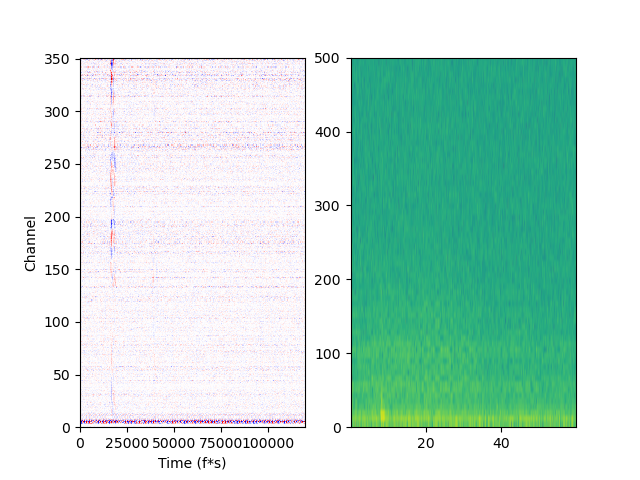

In [5]:
channel_spec = 350

fig, (ax1,ax2) = plt.subplots(1,2)

ax1.pcolorfast(filtered.T[:,:], cmap='seismic', vmin=-1, vmax=1)
ax1.set_ylabel('Channel')
ax1.set_xlabel('Time (f*s)')
ax2.specgram(filtered[:,channel_spec], NFFT=256, Fs=fs)
ax2.set_ylim([0,500])


plt.show()

# 3. Test triggering on an event

### Load a file with an event in it

In [13]:
file_list = sorted(glob('/1-fnp/petasaur/p-jbod1/antarctica2425/incoming/Eastwind_decimator_2024*'))
file = file_list[636]
print(file)

# Load data #
f = h5py.File(file)
attrs = f['Acquisition'].attrs
data = f['Acquisition']['Raw[0]']['RawData'][:]
this_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
times = sintela_to_datetime(this_time)
x = np.linspace(0,data.shape[1],data.shape[1]) * attrs['SpatialSamplingInterval']


fs = attrs['PulseRate'] #sample rate

data_normed = chan_norm(data)


sos = signal.butter(10, 1, 'hp', fs=fs, output='sos')
filtered = signal.sosfiltfilt(sos, data_normed, axis=0)

/1-fnp/petasaur/p-jbod1/antarctica2425/incoming/Eastwind_decimator_2024-12-19_03.17.00_UTC.h5


### Look at a single channel

In [16]:
channel = 350
channel_slice = filtered[:,channel]

DAS_channel = DAS(channel, channel_slice, attrs, times)

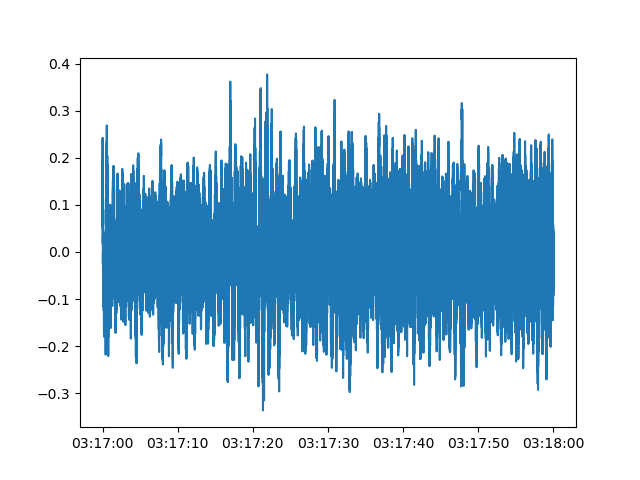

In [17]:
fig,ax = plt.subplots()
ax.plot(times, DAS_channel.data)

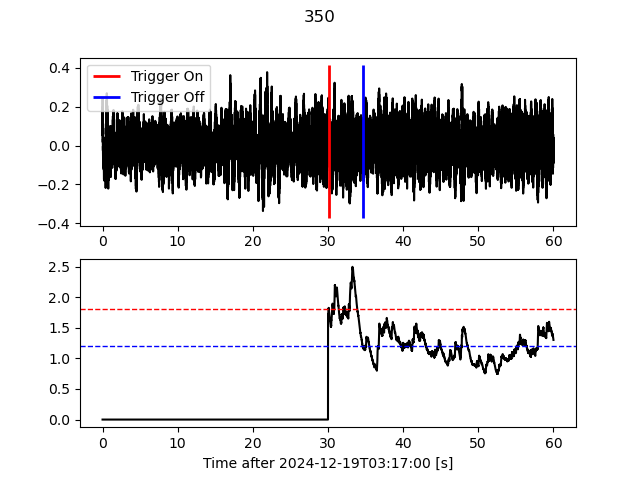

In [20]:
cft = recursive_sta_lta(DAS_channel.data, int(1 * fs), int(30 * fs))
plot_trigger(DAS_channel, cft, 1.8, 1.2)

# Picking with template matching

Template 1

/1-fnp/petasaur/p-jbod1/antarctica2425/incoming/Eastwind_decimator_2024-12-18_23.57.00_UTC.h5


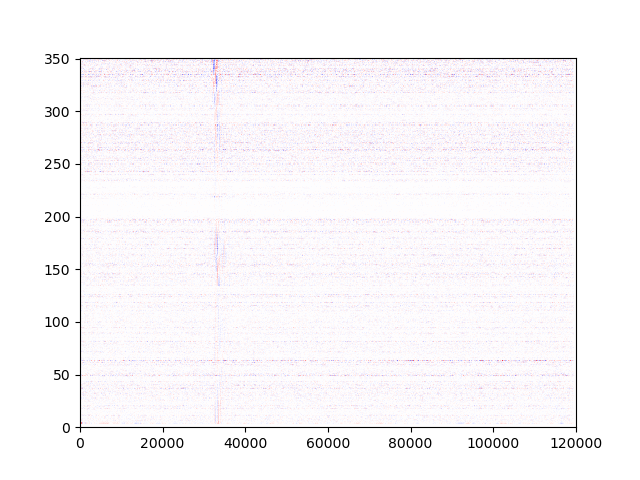

In [60]:
file_list = sorted(glob('/1-fnp/petasaur/p-jbod1/antarctica2425/incoming/Eastwind_decimator_2024*'))
file = file_list[436]
print(file)

# Load data #
f = h5py.File(file)
attrs = f['Acquisition'].attrs
data = f['Acquisition']['Raw[0]']['RawData'][:]
this_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
times = sintela_to_datetime(this_time)
x = np.linspace(0,data.shape[1],data.shape[1]) * attrs['SpatialSamplingInterval']


fs = attrs['PulseRate'] #sample rate

data_normed = chan_norm(data)


sos = signal.butter(10, [3,10], 'bp', fs=fs, output='sos')
filtered = signal.sosfiltfilt(sos, data_normed, axis=0)

fig, ax = plt.subplots()

ax.pcolorfast(filtered.T[:,:], cmap='seismic', vmin=-1, vmax=1)

In [47]:
templates = []

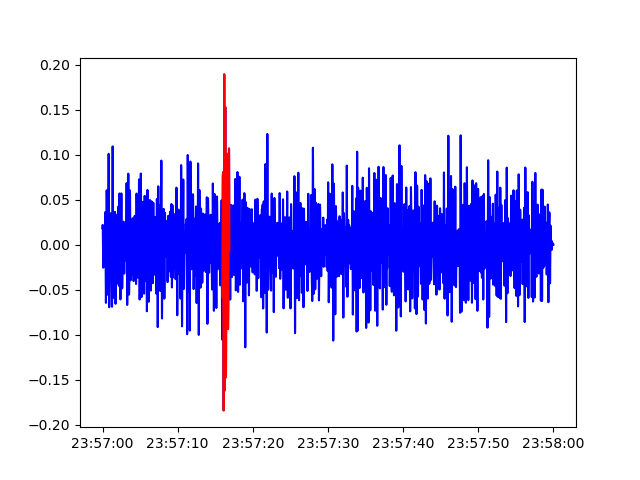

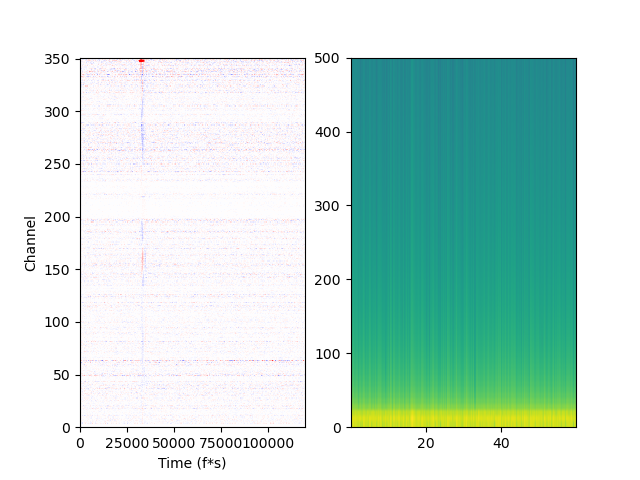

In [61]:
channel = 348
channel_slice = filtered[:,channel]


start_time = int(15.94*fs)
end_time = int(16.88*fs)
DAS_channel = DAS(channel, channel_slice, attrs, times)

fig,ax = plt.subplots()

ax.plot(times, DAS_channel.data, color='blue')
ax.plot(times[start_time:end_time], DAS_channel.data[start_time:end_time], color='red')
plt.show()

stats_default = {
    'network':'eastwind',
    'station':'',
    'location':'',
    'channel':'DAS',
    'starttime':times[start_time].strftime('%Y-%m-%dT%H:%M:%S.%fZ'),
    'endtime':times[end_time].strftime('%Y-%m-%dT%H:%M:%S.%fZ'),
    'sampling_rate':attrs['PulseRate'],
    'delta':1/attrs['PulseRate'],
    'npts':0,
    'calib':1.0
 }

tr_template = obspy.Trace(data=DAS_channel.data[start_time:end_time], header=stats_default)
tr_template.stats.npts = len(DAS_channel.data[start_time:end_time])

template_stream = obspy.Stream([tr_template])

fig, (ax1,ax2) = plt.subplots(1,2)

ax1.pcolorfast(filtered.T[:,:], cmap='seismic', vmin=-1, vmax=1)
ax1.set_ylabel('Channel')
ax1.set_xlabel('Time (f*s)')
ax2.specgram(filtered[:,channel], NFFT=256, Fs=fs)
ax2.set_ylim([0,500])
ax1.plot(np.arange(start_time,end_time), DAS_channel.data[start_time:end_time]+channel, color='red')


plt.show()

In [62]:
templates.append(template_stream)

# Do the template matching

In [67]:
file = file_list[436]
print(file)

# Load data #
f = h5py.File(file)
attrs = f['Acquisition'].attrs
data = f['Acquisition']['Raw[0]']['RawData'][:]
this_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
times = sintela_to_datetime(this_time)
x = np.linspace(0,data.shape[1],data.shape[1]) * attrs['SpatialSamplingInterval']


fs = attrs['PulseRate'] #sample rate

data_normed = chan_norm(data)


sos = signal.butter(10, [3,10], 'bp', fs=fs, output='sos')
filtered = signal.sosfiltfilt(sos, data_normed, axis=0)

/1-fnp/petasaur/p-jbod1/antarctica2425/incoming/Eastwind_decimator_2024-12-18_23.57.00_UTC.h5


In [68]:
st_list = obspy_stream_from_das(filtered, attrs, times)

In [73]:
picks = []
for st in st_list:
    detections, sims = obspy.signal.cross_correlation.correlation_detector(st,templates,0.6,1)
    picks.append(detections)

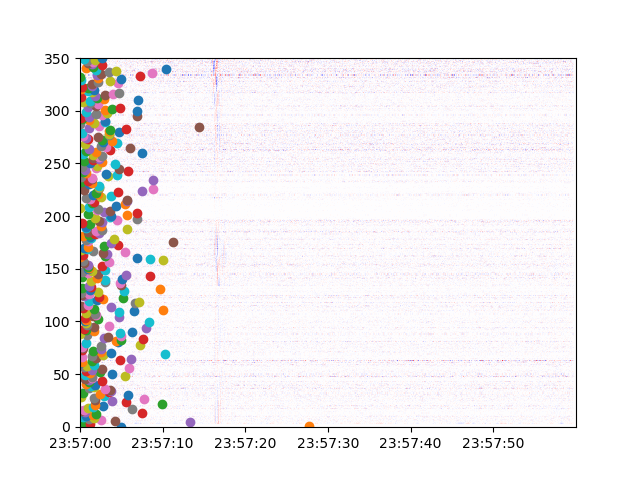

In [74]:
fig,ax = plt.subplots()
ax.pcolormesh(times, np.arange(0,len(x)),filtered.T[:,:], cmap='seismic', vmin=-1, vmax=1)
for n,i in enumerate(picks):
    if not i: continue
    else:
        ax.scatter(i[0]['time'], n)

# Coincidence trigger from obspy

In [2]:
from obspy.signal.trigger import coincidence_trigger

In [30]:
file_list = sorted(glob('/1-fnp/petasaur/p-jbod1/antarctica2425/incoming/Eastwind_decimator_2024*'))
file = file_list[634] #file_list[634] This is a good event
print(file)

/1-fnp/petasaur/p-jbod1/antarctica2425/incoming/Eastwind_decimator_2024-12-19_03.15.00_UTC.h5


In [31]:
# Load data #
f = h5py.File(file)
attrs = f['Acquisition'].attrs
data = f['Acquisition']['Raw[0]']['RawData'][:]
this_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
times = sintela_to_datetime(this_time)
x = np.linspace(0,data.shape[1],data.shape[1]) * attrs['SpatialSamplingInterval']


fs = attrs['PulseRate'] #sample rate

data_normed = chan_norm(data)


sos = signal.butter(10, [3,500], 'bp', fs=fs, output='sos')
filtered = signal.sosfiltfilt(sos, data_normed, axis=0)

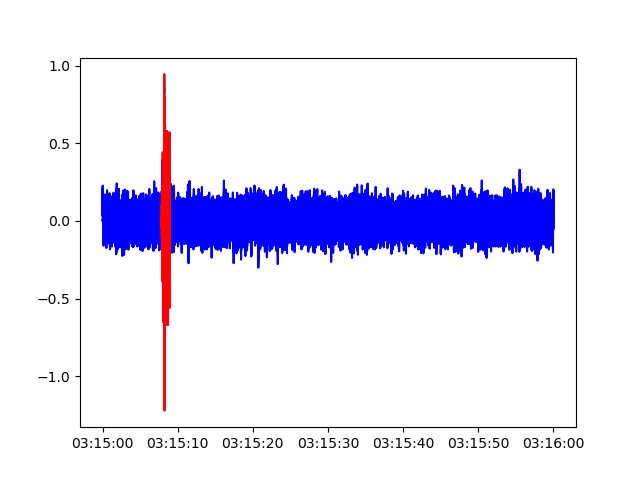

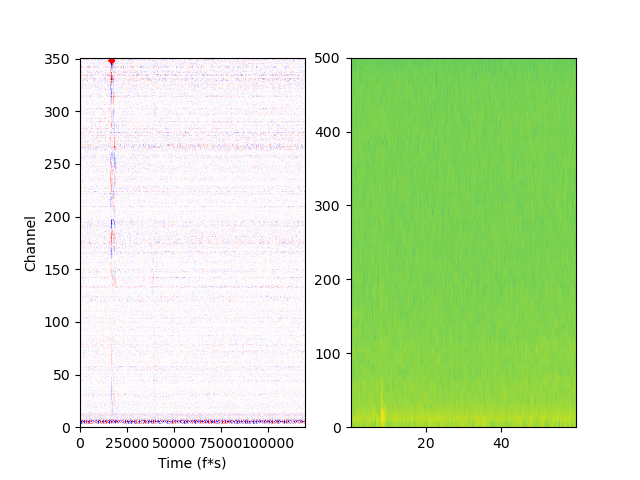

In [33]:
channel = 348
channel_slice = filtered[:,channel]


start_time = int(7.865*fs)
end_time = int(8.971*fs)
DAS_channel = DAS(channel, channel_slice, attrs, times)

fig,ax = plt.subplots()

ax.plot(times, DAS_channel.data, color='blue')
ax.plot(times[start_time:end_time], DAS_channel.data[start_time:end_time], color='red')
plt.show()

stats_default = {
    'network':'eastwind',
    'station':'',
    'location':'',
    'channel':'DAS',
    'starttime':times[start_time].strftime('%Y-%m-%dT%H:%M:%S.%fZ'),
    'endtime':times[end_time].strftime('%Y-%m-%dT%H:%M:%S.%fZ'),
    'sampling_rate':attrs['PulseRate'],
    'delta':1/attrs['PulseRate'],
    'npts':0,
    'calib':1.0
 }

tr_template = obspy.Trace(data=DAS_channel.data[start_time:end_time], header=stats_default)
tr_template.stats.npts = len(DAS_channel.data[start_time:end_time])

template_stream = obspy.Stream([tr_template])

fig, (ax1,ax2) = plt.subplots(1,2)

ax1.pcolorfast(filtered.T[:,:], cmap='seismic', vmin=-1, vmax=1)
ax1.set_ylabel('Channel')
ax1.set_xlabel('Time (f*s)')
ax2.specgram(filtered[:,channel], NFFT=256, Fs=fs)
ax2.set_ylim([0,500])
ax1.plot(np.arange(start_time,end_time), DAS_channel.data[start_time:end_time]+channel, color='red')


plt.show()

In [ ]:
event_templates = {'':[template_stream]}

In [34]:
event_templates[''].append(template_stream)

In [ ]:
from obspy.core import Stream

streams_all = obspy_stream_from_das(filtered, attrs, times)

{'': [1 Trace(s) in Stream:
eastwind...DAS | 2024-12-19T03:18:39.234002Z - 2024-12-19T03:18:39.749502Z | 2000.0 Hz, 1032 samples,
  1 Trace(s) in Stream:
eastwind...DAS | 2024-12-19T03:15:07.865001Z - 2024-12-19T03:15:08.970501Z | 2000.0 Hz, 2212 samples]}

In [47]:
similarity_thresholds = {"": 0.8}
trace_ids = {"eastwind...DAS": 1,}
trig = coincidence_trigger("classicstalta", 5, 1, streams_all[30], 4, sta=0.5,
                          lta=10, trace_ids=trace_ids,
                          event_templates=event_templates,
                          similarity_threshold=similarity_thresholds)

In [48]:
trig

[]

# Template match on only one channel so we can assess the whole collection quickly

# Load manual picks from before

In [25]:
### Load this if using a manual pick ###

with open("../manual_picked_events/manual_event_picks_236to288.pkl", "rb") as f_manual:
    picks = pkl.load(f_manual)

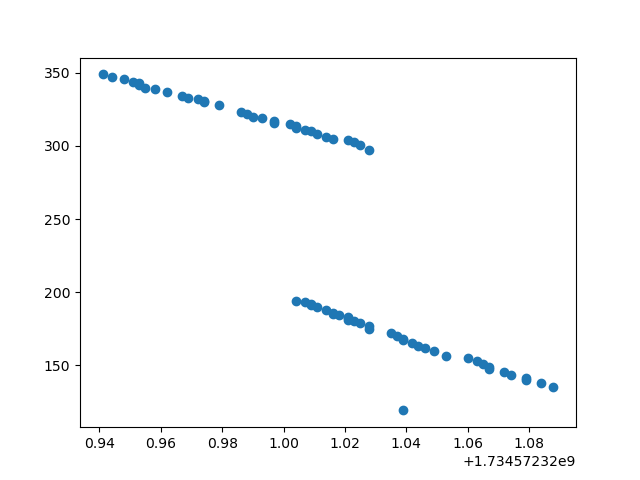

In [26]:
single_pick = np.array(picks['Event 288'][0])

fig,ax = plt.subplots()
ax.scatter(single_pick[:,1], single_pick[:,0])

# Do the picking again

In [ ]:
trigger_on = 1.8
trigger_off = 1.2

all_trigger_times = []

for i in tqdm(range(len(file_list))):
    if file_list[i][-9:-7] != '00':
        try:
            filt_filled_data, times, attrs = preprocessing_step(file_list[i])
        except: 
            continue
        

    else:
        first = copy.deepcopy(filt_filled_data)
        times_first = copy.deepcopy(times)
        try:
            filt_filled_data, times, attrs = preprocessing_step(file_list[i])
        except:
            continue
        
        # overlap_data[:,:] = filt_filled_data

        all_data = np.concatenate((first,filt_filled_data), axis=0)
        times_all = np.concatenate((times_first,times), axis=0)

        channels_arr = np.arange(0, attrs['NumberOfLoci'],1)


        trigger_times_list = []     

        for j in channels_arr:

            channel_slice = all_data[:,j]
            DAS_channel = DAS(j, channel_slice, attrs, times_all)

            cft = recursive_sta_lta(DAS_channel.data, int(1 * fs), int(3 * fs))
            trigger_times = trigger_onset(cft, trigger_on, trigger_off)

            trigger_times_list.append(trigger_times)

        trigger_times_list_datetime = []

        for trigs_samp_time in trigger_times_list:
            trigger_times_list_datetime.append(times_all[trigs_samp_time])
        
        all_trigger_times.append(trigger_times_list_datetime)      
          
        # fig,ax = plt.subplots()
        # ax.imshow(all_data,aspect='auto', vmin=-0.05,vmax=0.05)
    # if i == 5:
    #     break

# with open('all_chan_all_trigger_times_overlapped_new_STALTA.pkl', 'wb') as file:
#     # Serialize and write the data to the file
#     pkl.dump(all_trigger_times, file)

 40%|████      | 303/756 [40:28<1:01:09,  8.10s/it]